In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

import sys
__file__ = 'full_experiment.ipynb'
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = "4"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

Using TensorFlow backend.


In [2]:
config_vars["root_directory"] = 'DATA/FISH/'
experiment_name = '02'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [3]:
config_vars["no_boundary_labels_dir"] = 'DATA/FISH/no_boundary_labels/'
os.makedirs(config_vars["no_boundary_labels_dir"], exist_ok=True)

In [5]:
config_vars

{'root_directory': 'DATA/FISH/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': 'DATA/FISH/raw_images/',
 'raw_annotations_dir': 'DATA/FISH/raw_annotations/',
 'normalized_images_dir': 'DATA/FISH/norm_images/',
 'boundary_labels_dir': 'DATA/FISH/boundary_labels/',
 'experiment_dir': 'DATA/FISH/experiments/02/out/',
 'probmap_out_dir': 'DATA/FISH/experiments/02/out/prob/',
 'labels_out_dir': 'DATA/FISH/experiments/02/out/segm/',
 'path_files_training': 'DATA/FISH/experiments/02/tr

### PREPROCESS

<a list of 100 Patch objects>

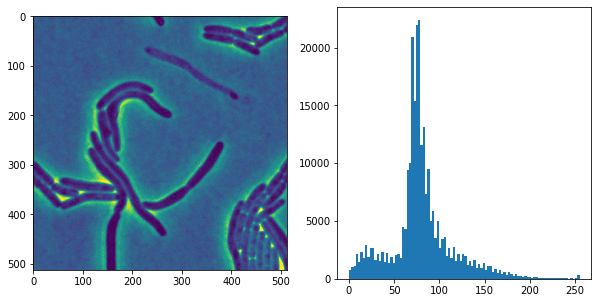

In [5]:
img = skimage.io.imread(config_vars["normalized_images_dir"] + '023/015.png')

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img)
ax[1].hist(img.flatten(), bins=100)[2]

--------------------------------

In [11]:
"""

'path_files_training': 'DATA/LinearTracking/training.txt',
'path_files_validation': 'DATA/LinearTracking/validation.txt',
'path_files_test': 'DATA/LinearTracking/test.txt',

folder 001 - 095 total 1585 images, 16.68 for one folder
setup dirs: `normalized` and `boundary label`
img list should contain file names like 001/0000.tif

"""  

fd_list = sorted(os.listdir('DATA/LineageTracking/raw_images/'))
# makedirs for 001, 002, ...
for f in fd_list:
    os.makedirs(config_vars["normalized_images_dir"] + f, exist_ok=True)
    os.makedirs(config_vars["boundary_labels_dir"] + f, exist_ok=True)   

In [14]:
"""split train, valid, test (image name list)

"""
train_fd_list = fd_list[:60]
valid_fd_list = fd_list[60:]

# boundary_labels_gai是清洗过后的labels
list_train = []
for f in train_fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/boundary_labels_gai/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for e in sorted(tmp_list):
        list_train.append(f + '/' + e)
        
list_valid = []
for f in valid_fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/boundary_labels/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for e in sorted(tmp_list):
        list_valid.append(f + '/' + e)
        
list_test = []


utils.dirtools.write_path_files(config_vars["path_files_training"], list_train)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_valid)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

In [11]:
# get these two lists for pre-process on all data
img_list = []
for f in fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/raw_images/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('tif')]
    for img in sorted(tmp_list):
        img_list.append(f + '/' + img)

mask_list = []
for f in fd_list:
    tmp_list = os.listdir('DATA/LineageTracking/raw_annotations/' + f)
    tmp_list = [x for x in tmp_list if x.endswith('png')]
    for mask in sorted(tmp_list):
        mask_list.append(f + '/' + mask)  

In [12]:
# normalize images

# filelist = sorted(os.listdir(config_vars["raw_images_dir"]))
filelist = img_list  # Lineage Tracking has second order directory

def normalize_original_img(filelist):
    for filename in tqdm(filelist):
        # load image and its annotation
        orig_img = skimage.io.imread(config_vars["raw_images_dir"] + filename)       
        # normalize to [0,1]
        percentile = 99.9
        high = np.percentile(orig_img, percentile)  # maximum for all image
        low = np.percentile(orig_img, 100-percentile)

        img = np.minimum(high, orig_img)
        img = np.maximum(low, img)

        # gives float64, thus cast to 8 bit later
        img = (img - low) / (high - low) 
        img = skimage.img_as_ubyte(img) 

        skimage.io.imsave(config_vars["normalized_images_dir"] + filename[:-3] + 'png', img)    

normalize_original_img(filelist)

  0%|          | 0/1585 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 1585/1585 [00:51<00:00, 30.66it/s]


In [6]:
# segmentation to boundary

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
# filelist = mask_list

def segment_to_label(filelist, total_objects = 0):
    for filename in tqdm(filelist):
        annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
        annot = skimage.morphology.label(annot)
        total_objects += len(np.unique(annot)) - 1
        annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])
        # find boundaries
        boundaries = skimage.segmentation.find_boundaries(annot)
        for k in range(2, config_vars["boundary_size"], 2):
            boundaries = skimage.morphology.binary_dilation(boundaries)

        # 3-CHANNEL BINARY LABEL
        # prepare buffer for binary label
        label_binary = np.zeros((annot.shape + (3,))) 
        label_binary[(annot == 0) & (boundaries == 0), 0] = 1  # bg
        label_binary[(annot != 0) & (boundaries == 0), 1] = 1  # cell
        label_binary[boundaries == 1, 2] = 1  # boundary
        # Convert an image to unsigned byte format, with values in [0, 255]
        label_binary = skimage.img_as_ubyte(label_binary)
        skimage.io.imsave(config_vars["boundary_labels_dir"] + filename, label_binary)
    print("Total objects: ",total_objects)
    
segment_to_label(filelist)

  0%|          | 0/339 [00:00<?, ?it/s]/home/lanbowen23/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
100%|██████████| 339/339 [00:55<00:00,  6.78it/s]


Total objects:  22162


In [9]:
# segmentation to boundary (no boundary channel)

filelist = sorted(os.listdir(config_vars["raw_annotations_dir"]))
filelist = [x for x in filelist if x.endswith('png')]
# filelist = mask_list

def segment_to_label(filelist, total_objects = 0):
    for filename in tqdm(filelist):
        annot = skimage.io.imread(config_vars["raw_annotations_dir"] + filename)
        annot = skimage.morphology.label(annot)
        total_objects += len(np.unique(annot)) - 1
        # filter small objects, e.g. micro nulcei
        annot = skimage.morphology.remove_small_objects(annot, min_size=config_vars["min_nucleus_size"])

        label_binary = np.zeros((annot.shape + (3,))) 
        label_binary[(annot == 0) , 0] = 1  # bg
        label_binary[(annot != 0) , 1] = 1  # cell
        label_binary[:,: , 2] = 0
        # Convert an image to unsigned byte format, with values in [0, 255]
        label_binary = skimage.img_as_ubyte(label_binary)
        skimage.io.imsave(config_vars["no_boundary_labels_dir"] + filename, label_binary)
    print("Total objects: ",total_objects)
    
segment_to_label(filelist)

100%|██████████| 339/339 [00:40<00:00,  8.38it/s]

Total objects:  22162


### TRAIN

#### Set Up Datasets

In [6]:
file_list = os.listdir(config_vars["normalized_images_dir"])
image_list = [x for x in file_list if x.endswith("png")]
len(image_list)

339

In [4]:
# set up train-valid split EVERY-TIME
def create_image_lists(dir_raw_images):
    file_list = os.listdir(dir_raw_images)
    image_list = [x for x in file_list if x.endswith("png")]
    image_list = sorted(image_list)

    image_list_train_aug = []
    image_list_test = []
#     image_list_train = []
#     image_list_validation = image_list
    
    image_list_validation = image_list[:48]
    image_list_2 = image_list[48:]
    random.shuffle(image_list_2)
    image_list_train = image_list_2
    return image_list_train, image_list_test, image_list_validation, image_list_train_aug

[list_training, list_test, list_validation, list_training_aug] = create_image_lists(
    config_vars["normalized_images_dir"],
#         config_vars["training_fraction"],
#         config_vars["validation_fraction"]
)

# write list into txt file
utils.dirtools.write_path_files(config_vars["path_files_training"], list_training)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_validation)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

##### data generator

In [5]:
# read txt file into dict partitions with 3 list for train/valid/test
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [7]:
# setup data-generator
train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

#### Traininig Model

In [8]:
"""
if train on no_boundary_label, change weight in utils.objectives.weighted_crossentropy

"""
model = utils.model_builder.get_model(config_vars["crop_size"], config_vars["crop_size"]) 
# model.summary()

#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"),   # delete bd, comment this
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

In [9]:
# Callbacks
log_folder = 'logs/'
csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])
tboard = keras.callbacks.TensorBoard(log_dir=log_folder + experiment_name, 
                                      histogram_freq=0, 
                                      batch_size=10, 
                                      write_graph=True, 
                                      write_grads=False, write_images=True,
                                      update_freq='epoch')
# add ModelCheckpoints
# monitor val-loss
weights_filename = log_folder + experiment_name + '/model-{epoch:02d}-{val_loss:.2f}.h5'
modelckp = keras.callbacks.ModelCheckpoint(weights_filename, verbose=1, save_weights_only=True,
                                           period=1, save_best_only=True)

# min_delta: threshold for measuring the new optimum,
#       to only focus on significant changes.
# cooldown: number of epochs to wait before resuming
#       normal operation after lr has been reduced.
reducelr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, 
                                             verbose=1, mode='min', min_lr=1e-7, 
                                             cooldown=10, min_delta=1e-4)
# min_lr could be smaller

earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, 
                              verbose=1, mode='auto', baseline=None, restore_best_weights=False)

callbacks = [csv, tboard, modelckp, reducelr, earlystop]

In [10]:
config_vars["epochs"] = 200

In [ ]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=config_vars["steps_per_epoch"],
    epochs=config_vars["epochs"],
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)
print('Done! :)')

# save one weight at the end of the training
model.save_weights(config_vars["model_file"])

Epoch 1/200
Training with 291 images.
500/500 [==============================] - 167s 334ms/step - loss: 0.0649 - categorical_accuracy: 0.9268 - background_recall: 0.9886 - background_precision: 0.9623 - interior_recall: 0.9963 - interior_precision: 0.8308 - boundary_recall: 0.0192 - boundary_precision: 0.8915 - val_loss: 0.1410 - val_categorical_accuracy: 0.9177 - val_background_recall: 0.9672 - val_background_precision: 0.9630 - val_interior_recall: 0.9994 - val_interior_precision: 0.7680 - val_boundary_recall: 0.0012 - val_boundary_precision: 0.8836

Epoch 00001: val_loss improved from inf to 0.14095, saving model to logs/02/model-01-0.14.h5
Epoch 2/200
500/500 [==============================] - 160s 320ms/step - loss: 0.0370 - categorical_accuracy: 0.9305 - background_recall: 0.9950 - background_precision: 0.9525 - interior_recall: 0.9980 - interior_precision: 0.8620 - boundary_recall: 0.0021 - boundary_precision: 0.9786 - val_loss: 0.1468 - val_categorical_accuracy: 0.9165 - val_b

### PREDICT

In [23]:
partition = "validation"
image_names = [os.path.join(config_vars["normalized_images_dir"], f) \
               for f in data_partitions[partition]]
imagebuffer = skimage.io.imread_collection(image_names)
images = imagebuffer.concatenate()

dim1 = images.shape[1]
dim2 = images.shape[2]
images = images.reshape((-1, dim1, dim2, 1))
# preprocess (assuming images are encoded as 8-bits in the preprocessing step)
images = images / 255

# build model and load weights
model = utils.model_builder.get_model_3_class(dim1, dim2)
model.load_weights(config_vars["model_file"])

# Normal prediction time
predictions = model.predict(images, batch_size=1)

In [26]:
empty_dir(config_vars["probmap_out_dir"])
empty_dir(config_vars["labels_out_dir"])

empty directory:  DATA/DNA_FISH/experiments/05/out/prob/
empty directory:  DATA/DNA_FISH/experiments/05/out/segm/


In [25]:
"""prepare gt annot & bd image names

rl: abrev. for raw label
bl: abrev. for boundary label
"""

rl_names = [os.path.join(config_vars["raw_annotations_dir"], f) \
               for f in data_partitions[partition]]
rl_buffer = skimage.io.imread_collection(rl_names) 

bl_names = [os.path.join(config_vars["boundary_labels_dir"], f) \
               for f in data_partitions[partition]]
bl_buffer = skimage.io.imread_collection(bl_names) 

In [ ]:
for i in range(len(images)):
    filename = imagebuffer.files[i]
#     imgname = os.path.basename(filename)
    filename_split = filename.split('/')
    imgname = '/' + filename_split[-2] + '/' + filename_split[-1]
#     print(filename, imgname)
    
    original_image = skimage.io.imread(filename)
    rl_image = skimage.io.imread(rl_buffer.files[i])
    bl_image = skimage.io.imread(bl_buffer.files[i])
    
    probmap = predictions[i].squeeze()
    os.makedirs(os.path.join(config_vars["probmap_out_dir"], filename_split[-2]), exist_ok=True)
    skimage.io.imsave(config_vars["probmap_out_dir"] + imgname, probmap.astype('uint8'))
    
    pred = utils.metrics.probmap_to_pred(probmap, config_vars["boundary_boost_factor"])
    label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])
    os.makedirs(os.path.join(config_vars["labels_out_dir"], filename_split[-2]), exist_ok=True)
    skimage.io.imsave(config_vars["labels_out_dir"] + imgname, label.astype('uint8'))
    
    if (i < 15):
        f, ax = plt.subplots(2,3,figsize=(12,8))
        ax[0][0].imshow(original_image)
        ax[0][0].title.set_text('original image')
        ax[0][1].imshow(bl_image)
        ax[0][1].title.set_text('ground truth boundary')
        ax[0][2].imshow(rl_image)
        ax[0][2].title.set_text('ground truth label')
        ax[1][0].imshow(pred)
        ax[1][0].title.set_text('predict boundary')
        ax[1][1].imshow(probmap)
        ax[1][1].title.set_text('predict boundary probmap')
        ax[1][2].imshow(label)
        ax[1][2].title.set_text('predict label')
        for a in ax:
            for a_ in a:
                a_.set_xticks([])
                a_.set_yticks([])
        plt.show()
        
#     if (i == 15):
#         break


------------------------------

### beautify boundary

In [97]:
config_vars["model_file"] = 'DATA/LineageTracking/experiments/11/model.hdf5'

In [98]:
"""

On 1 image, prediction procedure: predict->fix->label
from label get 1 cell image
special case: cell bending

1. use find_contours to get contours,
   select points, beautify, polygon draw
   this method can be recursively used
2. use convex_hull
   but this is not useful for bending cell!
3. try closing

reference:


""" 
model = utils.model_builder.get_model_3_class(512, 512)
model.load_weights(config_vars["model_file"])

img = os.path.join(config_vars['normalized_images_dir'], '061/019.png')
img = skimage.io.imread(img)
img = (img/255).reshape((-1,512,512,1))

out = model.predict(img, batch_size=1)
out = out[0]

float32 8.445248 0.0
int64 2 0 (512, 512) [0 1 2]


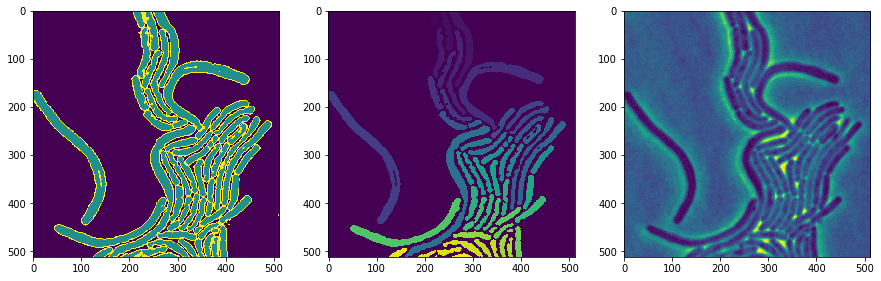

In [99]:
"""
out: prob map output
pred: fixed prob map
label: instance segmentation from pred's cell channel
"""

bd = out[:,:,2]  # channel 2 is boundary prob
print(bd.dtype, bd.max(), bd.min())  # why max is 7.6

# fix pixel value to its biggest channel number(0 1 2)
pred = utils.metrics.probmap_to_pred(out, config_vars["boundary_boost_factor"])
print(pred.dtype, pred.max(), pred.min(), pred.shape, np.unique(pred))

# first cell=(pred==1), extract out channel 1 cell/interior
# then use skimage label to get instance segmentation
label = utils.metrics.pred_to_label(pred, config_vars["cell_min_size"])

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(pred)
ax[1].imshow(label)
ax[2].imshow(img.squeeze())

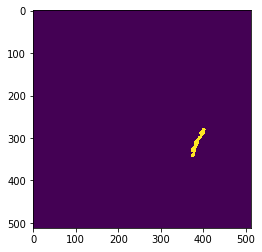

In [100]:
"""
pick out one cell into `single` array
get boundary of it into `bd` array
25 small;  10 large bending;  9 small bending
smooth/good looking one
"""

single = np.zeros(label.shape)
single[label==25] = 1

bd = skimage.segmentation.find_boundaries(single)

plt.imshow(single)

In [56]:
def save_cell(cell, save_name, mode='npy'):
    if mode == 'npy':
        np.save(save_name, cell) 
    if mode == 'img':
        skimage.io.imsave(save_name + '.png', cell) # directly change to 0 255
        
def load_cell(name, mode='npy'):
    if mode == 'npy':
        c = np.load(name + '.npy')
    if mode == 'img':
        c = skimage.io.imread(name + '.png')
        c = np.array(c)
    return c

In [101]:
def get_cell_coord(cell):
    px_nb = int(np.sum(cell))
    cell_coord = np.zeros((px_nb,2), dtype='uint16')
    c = 0
    for i in range(cell.shape[0]):
        for j in range(cell.shape[1]):
            if cell[i][j] == 1:
                cell_coord[c] = [i,j]
                c = c + 1
    assert c == px_nb
    return cell_coord
            
cc = get_cell_coord(single)
print(cc[:,0].min(), cc[:,1].min())
cc[:,0] = cc[:,0] - cc[:,0].min()
cc[:,1] = cc[:,1] - cc[:,1].min()
print(cc[:,0].min(), cc[:,1].min())


276 370
0 0


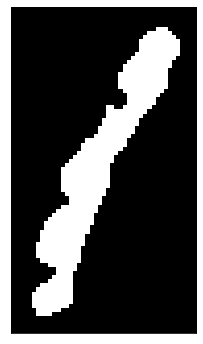

In [102]:
def put_cell_coord(coord):
    x = coord[:,0].max() + 10
    y = coord[:,1].max() + 10
    cell = np.zeros((x,y))
    for c in coord:
        cell[c[0]+5, c[1]+5] = 1
    return cell

c = put_cell_coord(cc)
fig = plt.figure(figsize = (6,6)) 
ax = fig.add_subplot(111)
plt.xticks([])
plt.yticks([])
ax.imshow(c, cmap='gray')

In [96]:
fn = 'rough'
save_cell(c, fn, mode='img')

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [65]:
c2 = load_cell(fn)
(c == c2).all()

True

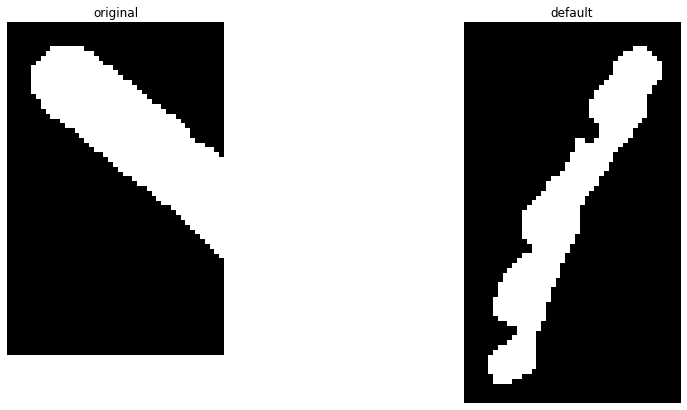

In [68]:
plot_comparison(load_cell('smooth'), load_cell('rough'))

In [103]:
from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, subdivide_polygon
from skimage.draw import polygon

bd = bd.astype('uint8')

(584, 2)
0
1
2


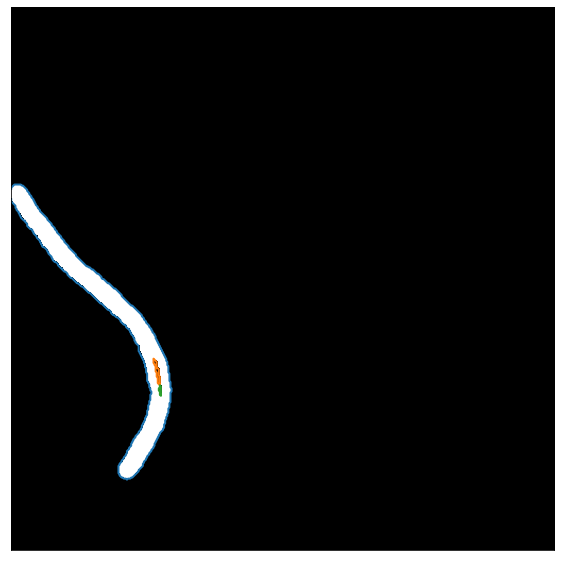

In [433]:
"""
test find_contours
"""
from skimage import measure

r = single
# Find contours at a constant value of 0.8
# level : float Value along which to find contours in the array.
contours = measure.find_contours(r,0) 
print(contours[0].shape)
# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    print(n)
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [23]:
"""
contours(boundary points) have the `order` to connect them back

ind (#, 2): random chooson boundary points -> (plot onto image) bd2 
new_ind: beautify 
PROBLEM:
not stable

PROBLEM using our predictions for picking boundary pixel position 
- will not have the `order` to plot them back
- random choose leads to missing part

"""

# ori_ind = np.where(bd==1)  
# print(ori_ind[0].shape)
# buf = np.zeros((328, 2))
# buf[:, 0] = ori_ind[0]
# buf[:, 1] = ori_ind[1]


r = single
contours = find_contours(r,0)
cnt = np.array(contours[0]).squeeze()  # sometimes there are several sets of contours
print(cnt.shape)

# random choose 50 points
# choose half fixed points
# import random
choose = int(cnt.shape[0]/2)
# rand = random.sample(range(cnt.shape[0]), choose)
# rand = sorted(rand)
l = range(cnt.shape[0] - 1)
print(choose)

ind = np.zeros((choose, 2), dtype='uint16')
ind = cnt[l[::2]]
# ind = cnt
# ind[:,0] = cnt[rand_ind][0]
# ind[:,1] = cnt[rand_ind][1]

new_ind = ind.copy()
for _ in range(10):
    new_ind = subdivide_polygon(new_ind, degree=2, preserve_ends=True)
# appr_ind = approximate_polygon(new_ind, tolerance=0.02)

"""
use `draw polygon` to fill in the discrete boundary points in `new_ind`
"""


img = np.zeros(single.shape)
r = new_ind[:,0]
c = new_ind[:,1]
rr, cc = polygon(r, c)
img[rr, cc] = 1  # interesting, x y can be list

fig, ax = plt.subplots(1,2,figsize=(15,8))
ax[0].imshow(single)
ax[1].imshow(img)

In [ ]:
"""
put points pairs onto image array
"""

bd2 = np.zeros(pred.shape)
bd3 = np.zeros(pred.shape)
for i in ind.astype('uint16'):
    bd2[i[0]][i[1]] = 1
for i in new_ind.astype('uint16'):
    bd3[i[0]][i[1]] = 1

fig, ax = plt.subplots(1,2,figsize=(15,8))
# ax[0].plot(ind[:, 0], ind[:, 1], '-r', linewidth=2)
# ax[1].plot(new_ind[:, 0], new_ind[:, 1], '-r', linewidth=2)
ax[0].imshow(bd2)
ax[1].imshow(bd3)

In [104]:
def plot_comparison(original, filtered, filter_name='default'):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 7), sharex=True, sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

In [105]:
def contour_smooth(scell):
    # Find contours at a constant value of 0
    # level : float Value along which to find contours in the array.
    contours = find_contours(scell, 0)
    cnt = np.array(contours[0]).squeeze()  # sometimes there are several sets of contours
    
    interval = 3
    choose = int(cnt.shape[0]/interval)
#     rand = sorted(random.sample(range(cnt.shape[0]), choose))
    ind = np.zeros((choose, 2), dtype='uint16')
    ind = cnt[range(cnt.shape[0] - 1)[::interval]]
#     print(len(ind))
    
    new_ind = ind.copy()
    for _ in range(5):
        new_ind = subdivide_polygon(new_ind, degree=2, preserve_ends=True)
        
    ncell = np.zeros(scell.shape)
    r = new_ind[:,0]
    c = new_ind[:,1]
    rr, cc = polygon(r, c)
    ncell[rr, cc] = 1
    return ncell

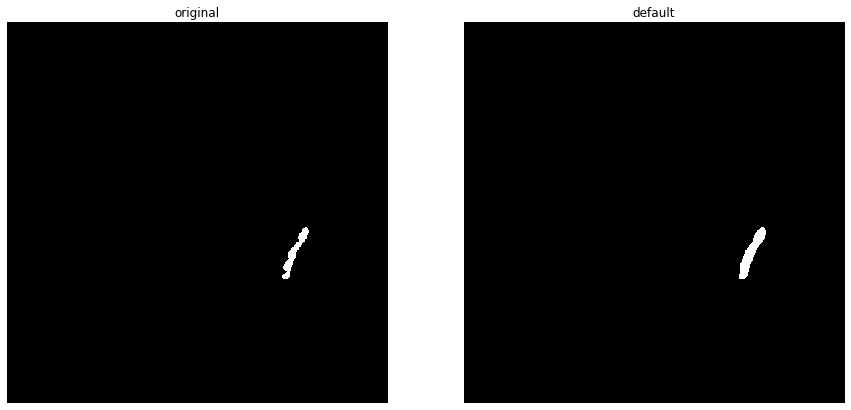

In [106]:
rec = contour_smooth
s = single.copy()
for i in range(4):
    s = rec(s)
    single_2 = s
    
plot_comparison(single, single_2)

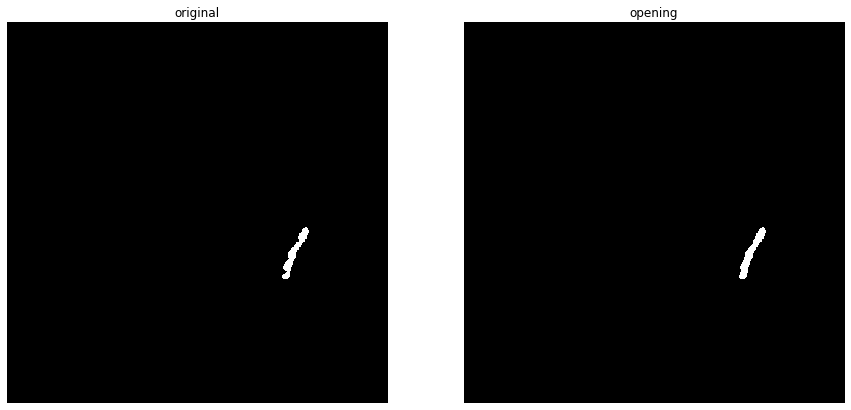

In [107]:
"""
try closing or opening 
"""
from skimage.morphology import disk, opening, closing

selem = disk(10)
closed = closing(single, selem)
# closed = closing(closed, selem)
# closed = closing(closed, selem)
plot_comparison(single, closed, 'opening')


In [342]:
"""
lesson:
matplot not easy to be transformed back to numpy array
cv2 has problem to run
"""

from matplotlib import path
from numpy import ma
closed_path = path.Path(contour)
r = single
# Get the points that lie within the closed path
idx = np.array([[(i,j) for i in range(r.shape[0])] for j in range(r.shape[1])]).reshape(np.prod(r.shape),2)
mask = closed_path.contains_points(idx).reshape(r.shape)

# Invert the mask and apply to the image
mask = np.invert(mask)
masked_data = ma.array(r.copy(), mask=mask)

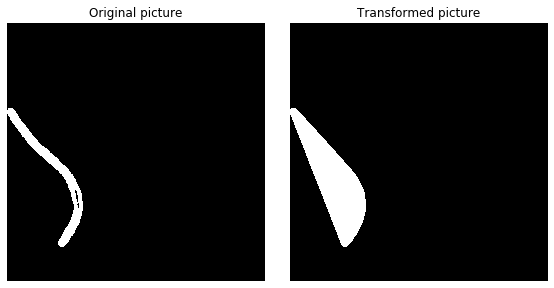

In [446]:
"""
convex hull not work for bending object
"""

from skimage.morphology import convex_hull_image, convex_hull_object

image = single
chull = convex_hull_image(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray)
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

----------------------------------------

### Evaluation

In [408]:
"""
understand sum operation
"""

a = np.arange(12).reshape(3,4)
print(a[0])
np.sum(a, axis=0)

[0 1 2 3]


array([12, 15, 18, 21])

In [399]:
"""

ground_truth: raw_annotation
prediction: predict instance label

IOU:
axis 0 -> gt label
axis 1 -> pred label

missed: non pred for the gt
extra: non gt for the pred
"""

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    # Compute Intersection over Union
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)

    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    diff2 = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    diff2[D > 0, 0] = 1
    diff2[D < 0, 2] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis=1) == 0)[0]  
    extra = np.where(np.sum(C, axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 5, figsize=(20,5))
    ax[0].imshow(ground_truth)
    ax[0].set_title("Ground Truth objects: " + str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segment errors: miss {}, extra {}.".format(str(len(missed)), str(len(extra))))
    ax[2].imshow(prediction)
    ax[2].set_title("Predict objects:" + str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name + " IOU")
    ax[4].imshow(diff2)

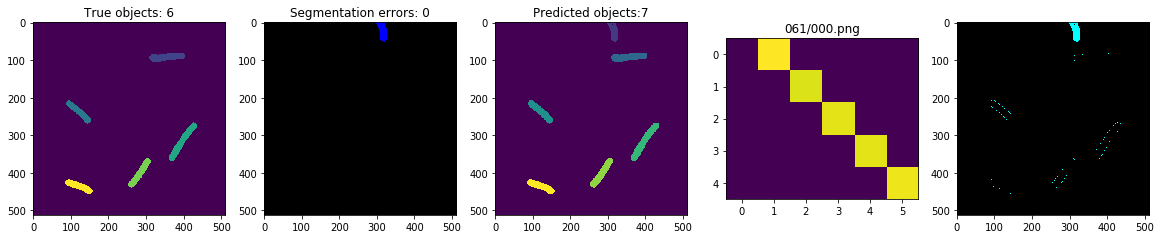

In [400]:
"""Metrics

Jaccard: IOU match average

True Pos: IOU match and only one match
False Pos: extra pred label match non gt
False Neg: missed gt label match non pred
Precision: TP / (TP + FP + 1e-9)
Recall: TP / (TP + FN)
F1: 2 * TP / (2 * TP + FP + FN + 1e-9)

False_neg area: missed gt label area

Merge: one pred label match two gt label
Split: one gt label match two pred label

"""


all_images = data_partitions["validation"]  

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Precision", "Recall", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    # Load ground truth label
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
#     if len(ground_truth.shape) == 3:
#         ground_truth = ground_truth[:,:,0]

    # to make the order same as predict label
    ground_truth = skimage.morphology.label(ground_truth)
    
    pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
    prediction = skimage.io.imread(pred_filename)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)
        
    # waste
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    if image_name == all_images[0]:
        show(ground_truth, prediction, image_name=image_name)

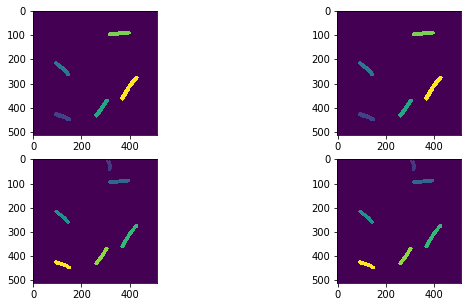

In [421]:
image_name = all_images[0]
img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
ground_truth = skimage.io.imread(img_filename)
# Transform to label matrix ??? why necessary
# ground_truth_l = skimage.morphology.label(ground_truth)
# a = ground_truth_l == ground_truth
# np.where(a==False)

pred_filename = os.path.join(config_vars["labels_out_dir"], image_name)
prediction = skimage.io.imread(pred_filename)
    
ground_truth_l = skimage.segmentation.relabel_sequential(ground_truth)[0]
prediction_l = skimage.segmentation.relabel_sequential(prediction)[0]

f, ax = plt.subplots(2,2,figsize=(10,5))
ax[0][0].imshow(ground_truth_l)
ax[0][1].imshow(ground_truth)
ax[1][0].imshow(prediction_l)
ax[1][1].imshow(prediction)

In [401]:
average_performance = results.groupby("Threshold").mean().reset_index()
average_performance

,Threshold,F1,Precision,Recall,Jaccard
0,0.50,0.761907,0.675266,0.898234,0.644103
1,0.55,0.729708,0.647580,0.858126,0.644103
2,0.60,0.718896,0.638126,0.844557,0.644103
3,0.65,0.710186,0.630612,0.833357,0.644103
4,0.70,0.698516,0.620567,0.818751,0.644103
5,0.75,0.682332,0.606529,0.798886,0.644103
6,0.80,0.651845,0.579864,0.761993,0.644103
7,0.85,0.614028,0.546412,0.717399,0.644103
8,0.90,0.569066,0.506890,0.663311,0.644103
9,0.95,0.297126,0.265168,0.344983,0.644103


In [ ]:
R = results.groupby("Image").mean().reset_index()
R.sort_values(by="F1", ascending=False)

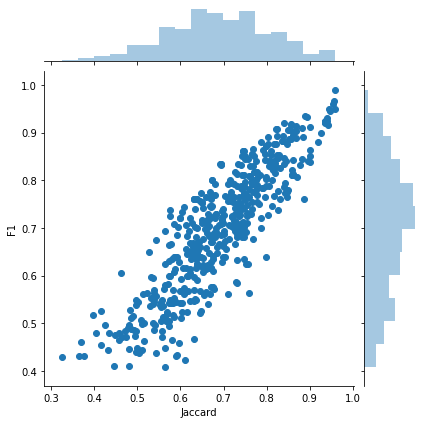

In [403]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

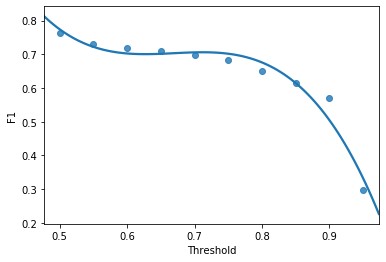

In [404]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [405]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0, 250, 625, 900, 10000], # Area intervals
        labels = ["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

# Summarize splits and merges

print("Splits:", np.sum(splits_merges["Splits"]))
print("Merges:", np.sum(splits_merges["Merges"]))

# Report false positives

print("Extra objects (false postives): ", 
      results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Average F1 score: 0.643361055658659
Jaccard index: 0.6441032366617988
Splits: 1034
Merges: 389
Extra objects (false postives):  6569


### PRINT Results

In [ ]:
images_dirs = ['DATA/DNA_FISH/norm_images/',
              'DATA/IF_images/norm_images/',
              'DATA/Lineage_Tracking_ZY/norm_images/',
              'DATA/Lineage_Tracking_KZ/norm_images/']

labels_dirs = ['DATA/DNA_FISH/experiments/04/out/segm/',
              'DATA/IF_images/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_ZY/experiments/04/out/segm/',
              'DATA/Lineage_Tracking_KZ/experiments/04/out/segm/']

In [ ]:
def difference(raw_label, pred_label):
    ground_truth = raw_label.copy()
    prediction = pred_label.copy()
    IOU = utils.evaluation.intersection_over_union(ground_truth, prediction)
    diff = np.zeros(ground_truth.shape + (3,))  # become 3 channels
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    threshold = 0.5  # if set to 0.8, more misses will appear, but 0.5 no miss
    C[C >= threshold] = 1
    C[C < threshold] = 0
    missed = np.where(np.sum(C, axis = 1) == 0)[0]  # for original cell, none predict cell match 
    extra = np.where(np.sum(C, axis = 0) == 0)[0]  # for predict cell, none original cell match

    for m in missed:
        diff[ground_truth == m + 1, 0] = 1
    for e in extra:
        diff[prediction == e + 1, 2] = 1
        
    return diff, str(len(missed)), str(len(extra))

In [ ]:
def compare(img_name):
    original_images = []
    pred_labels = []
    for i in range(4):
        ori_img_filename = os.path.join(images_dirs[i], img_name)
        original_image = skimage.io.imread(ori_img_filename)
    
        pred_label_filename = os.path.join(labels_dirs[i], img_name)
        pred_label = skimage.io.imread(pred_label_filename)
        
        struct = skimage.morphology.square(3)
        pred_label = skimage.morphology.dilation(pred_label, struct)
        pred_label = skimage.segmentation.relabel_sequential(pred_label)[0] #[30:-30,30:-30])[0]
            
        # make graph easier to look
        inc = lambda x: x if x == 0 else x + 100
        inc = np.vectorize(inc)
        pred_label = inc(pred_label)
        
        original_images.append(original_image)
        pred_labels.append(pred_label)
        
    fig, ax = plt.subplots(2, 4, figsize=(20,10))
    fig.suptitle(img_name)
    ax[0][0].set_title("DNA_FISH")
    ax[0][0].imshow(original_images[0])
    ax[0][1].set_title("IF_images")
    ax[0][1].imshow(original_images[1])
    ax[0][2].set_title("Linear_Tracking_zy")
    ax[0][2].imshow(original_images[2])
    ax[0][3].set_title("Linear_Tracking_kz")
    ax[0][3].imshow(original_images[3])
    
#     ax[1][0].set_title("DNA_FISH")
    ax[1][0].imshow(pred_labels[0])
#     ax[1][1].set_title("IF_images")
    ax[1][1].imshow(pred_labels[1])
#     ax[1][2].set_title("Linear_Tracking_zy")
    ax[1][2].imshow(pred_labels[2])
#     ax[1][3].set_title("Linear_Tracking_kz")
    ax[1][3].imshow(pred_labels[3])


    # plt.figure(figsize=(6,6))
    # plt.imshow(original_image)  #, cmap="nipy_spectral")
    # plt.show()

In [ ]:
for i in np.random.randint(74, size = 20):
    img = "{:04}".format(i) + ".png"
    compare(img)